# Predicting House Prices - Kaggle Competition

This notebook is my submission for the [Kaggle House Prices Competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques), which contains a dataset containing the the features of 1460 houses, plus their selling prices. 

This notebook uses several different regression methodologies in order to predict the price of a house given its features (its area, how many bedrooms it has, the year it was built, etc). My methodology is outlined as follows:

- Load the dataset into a Pandas dataframe
- Feature selection:
    - Identify which numerical features to keep based on their correlation with the sales price
        - Identify which features to keep from those based on their correlation with each other
    - Identify which categorical features to keep
- Handle missing data
- Feature Engineering
- Data Pre-Processing:
    - One-hot encode the categorical features
    - Standardise and normalise the numerical features 
- Perform different regression models on the data and compare their performance (in terms of MRSE):
    - Linear Regression
    - Ridge Regression
    - Lasso Regression
    - Random Forest
    - Support Vector Machine
    - Extreme Gradient Boosting
- Make the submission on the test data

## Import libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Feature Selection

In [2]:
train_data = pd.read_csv('train.csv')
train_data.shape

(1460, 81)

So the training data contains the data for 1460 houses, and contains 81 features.

### Heatmap for correlations between each numerical feature and the selling price

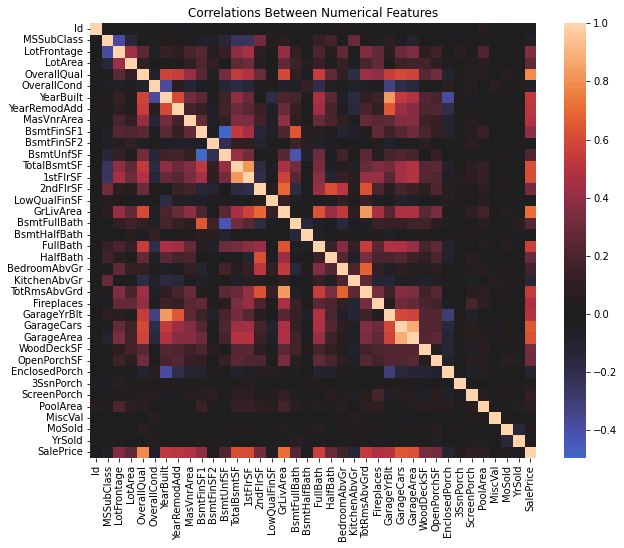

In [3]:
c_matrix = train_data.corr()
plt.figure(figsize=(10,8))
sns.heatmap(c_matrix, center=0)
plt.title("Correlations Between Numerical Features")
plt.show()

Great! Now, we need to only choose features that have a moderate effect on the selling price. Without loss of generality, let's choose features that have a correlation with the selling price of 0.5 or above.

In [4]:
c_matrix = train_data.corr()
numerical_to_keep = c_matrix['SalePrice'][abs(c_matrix['SalePrice']) >= 0.5]
numerical_to_keep

OverallQual     0.790982
YearBuilt       0.522897
YearRemodAdd    0.507101
TotalBsmtSF     0.613581
1stFlrSF        0.605852
GrLivArea       0.708624
FullBath        0.560664
TotRmsAbvGrd    0.533723
GarageCars      0.640409
GarageArea      0.623431
SalePrice       1.000000
Name: SalePrice, dtype: float64

In [5]:
numerical_to_keep = list(numerical_to_keep.index)
numerical_to_keep.remove('SalePrice')
numerical_to_keep

['OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'GarageCars',
 'GarageArea']

Now that we have our list of features that correlate with the sale price, we need to see if there is a correlation between any of these variables. If there is, then there is no point including it in the model, because if two features affect each other, then we are not losing any information by taking one out, and it's less computationally intense to have fewer features. 

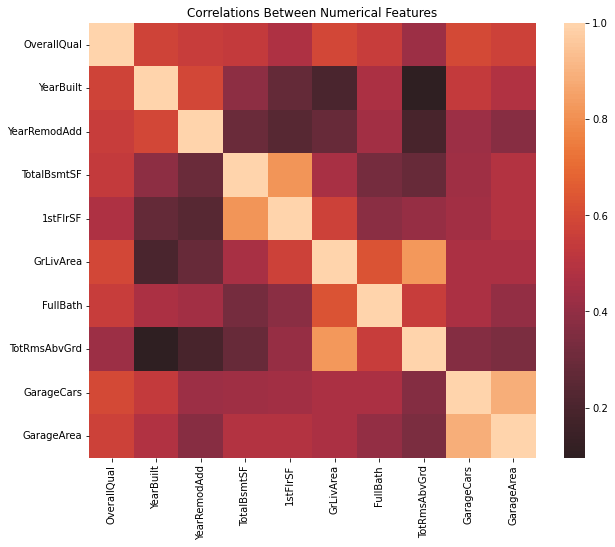

In [6]:
plt.figure(figsize=(10,8))
sns.heatmap(train_data[numerical_to_keep].corr(), center=0)
plt.title("Correlations Between Numerical Features")
plt.show()

Let's remove (one of) the features that have a correlation of above 0.6 with each other.

In [7]:
c_matrix = train_data[numerical_to_keep].corr()

for i in range(len(numerical_to_keep)):
    for j in range(i+1, len(numerical_to_keep)):
        if abs(c_matrix[numerical_to_keep[i]][numerical_to_keep[j]]) > 0.6:
            print(numerical_to_keep[i], numerical_to_keep[j], \
                  c_matrix[numerical_to_keep[i]][numerical_to_keep[j]])

OverallQual GarageCars 0.6006707165907149
TotalBsmtSF 1stFlrSF 0.8195299750050339
GrLivArea FullBath 0.6300116462511148
GrLivArea TotRmsAbvGrd 0.8254893743088425
GarageCars GarageArea 0.882475414281462


I have made the decision to remove 'GarageCars', 'TotalBsmtSF', 'FullBath', and 'TotRmsAbvGrd'. This will remove some of the 'repeated information' (as it were) from the features.

In [8]:
numerical_to_keep.remove('GarageCars')
numerical_to_keep.remove('TotalBsmtSF')
numerical_to_keep.remove('FullBath')
numerical_to_keep.remove('TotRmsAbvGrd')

Now that we have the numerical features sorted, we need to decide which categorical features to select. For this I am going to contruct a boxplot for each feature and the sale price, and if there is not much overlap between the boxes, then it's safe to assume a stronger association, so we can include these features in the regression models. Unfortunately, there are 43 categorical variables, so I have no choice but to view each plot individually and manually look at them.

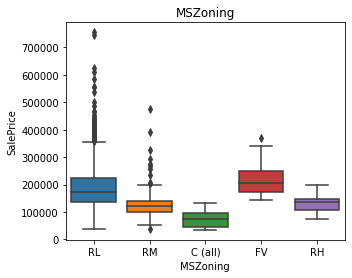

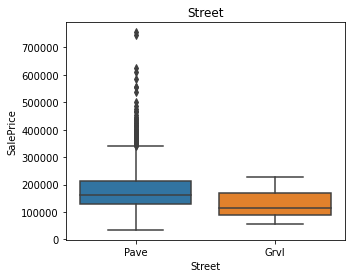

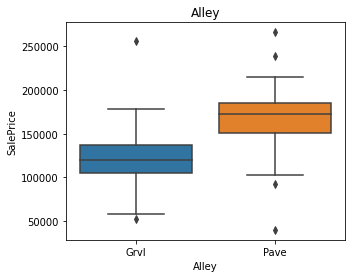

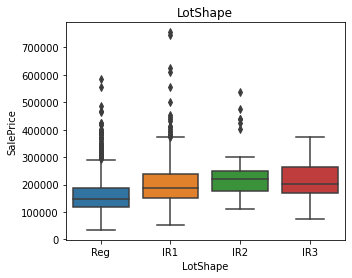

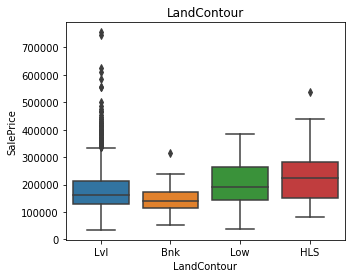

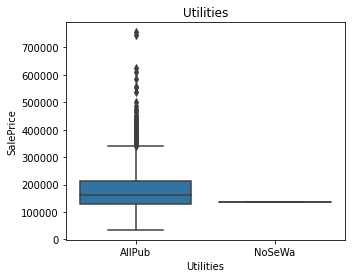

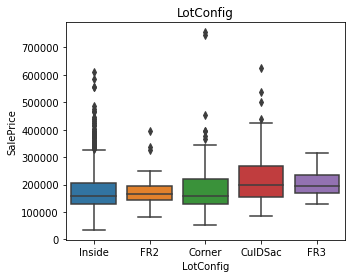

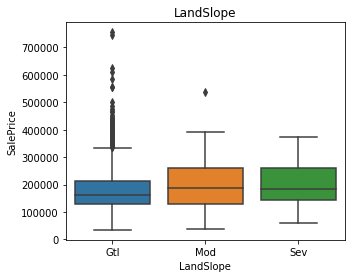

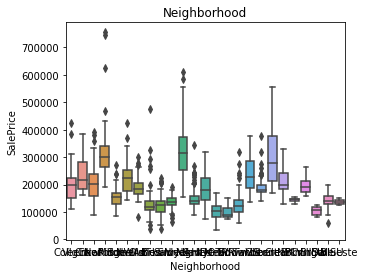

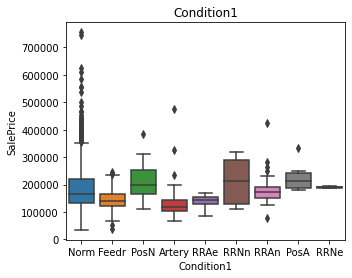

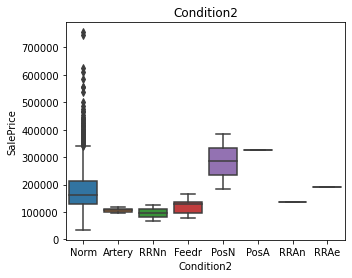

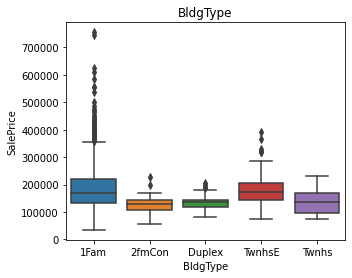

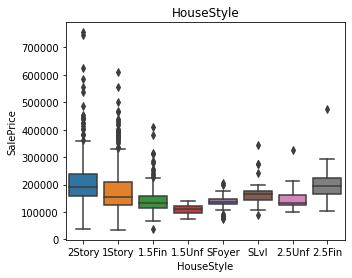

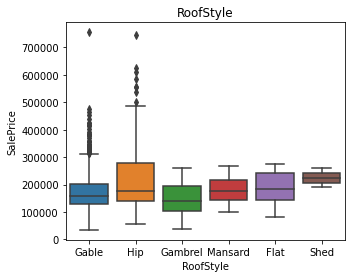

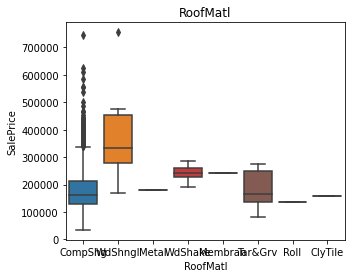

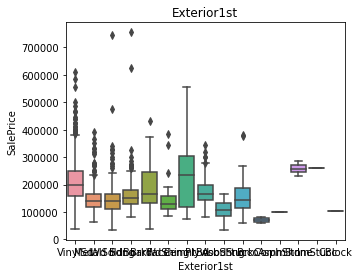

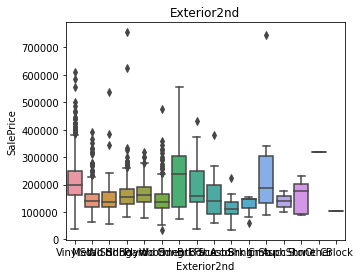

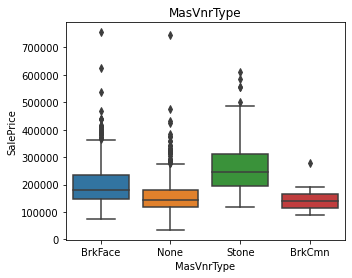

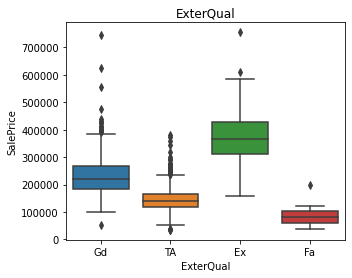

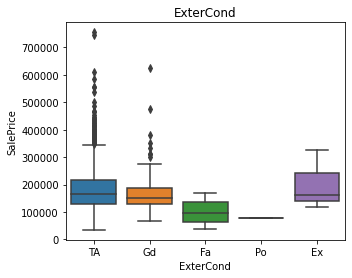

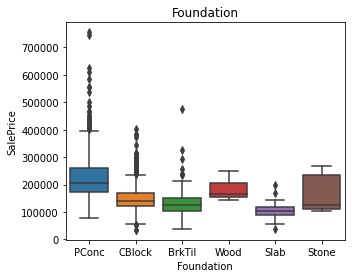

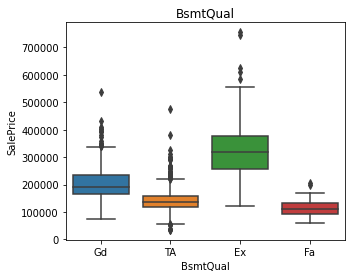

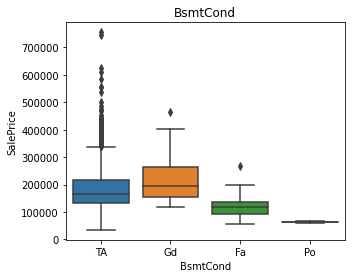

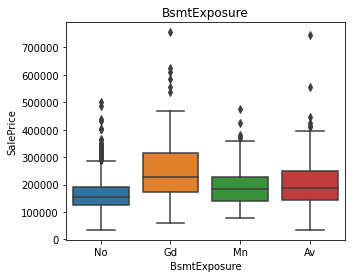

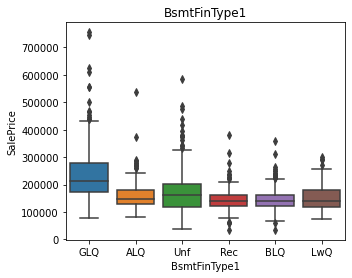

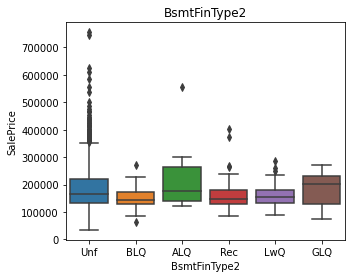

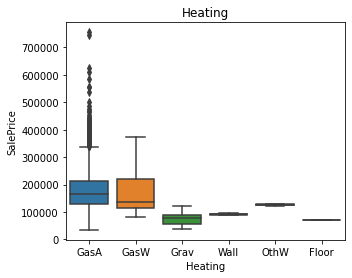

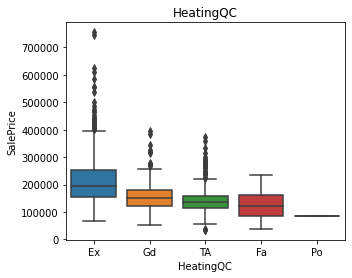

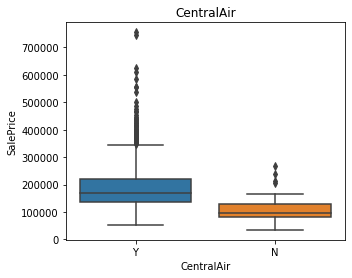

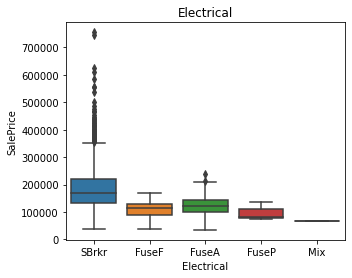

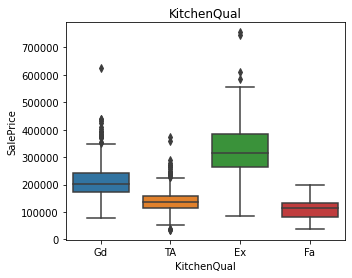

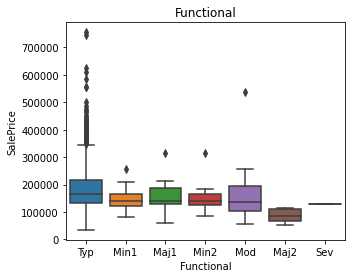

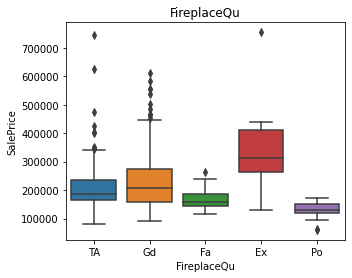

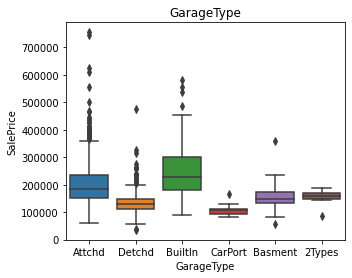

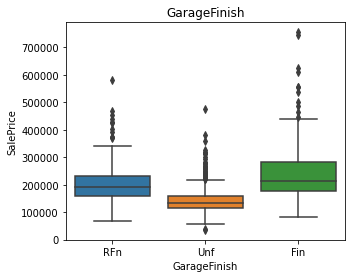

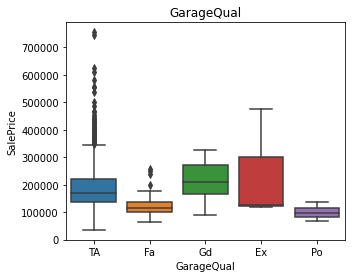

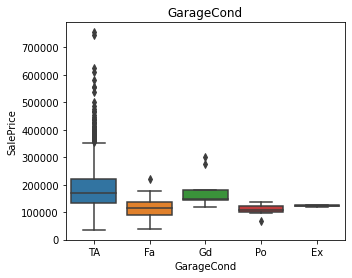

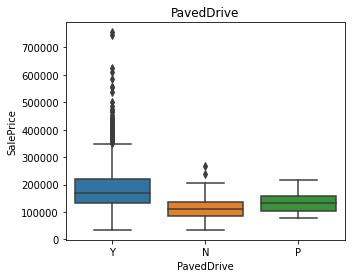

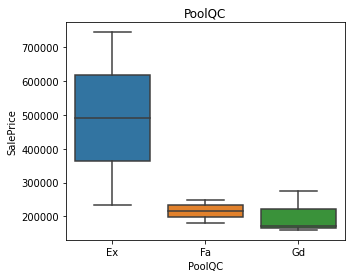

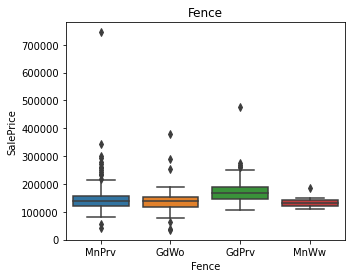

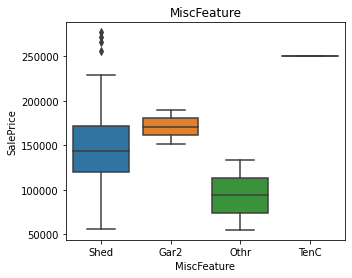

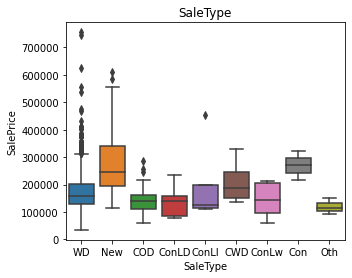

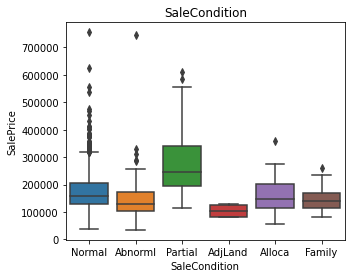

In [9]:
objects = train_data.select_dtypes(include='object')

for feature in objects.dtypes.index:
    plt.figure(figsize=(5,4))
    sns.boxplot(data=train_data, x=feature, y='SalePrice')
    plt.title(str(feature))
    plt.show()


It looks like the following features seem to have not much overlap, and thus a stronger association:
- MSZoning
- Alley
- Condition2
- BldgType
- MasVnrType
- ExterQual
- BsmtQual
- CentralAir
- KitchenQual
- FireplaceQu
- GarageFinish
- PoolQC
- MiscFeature
- SaleType
- SaleCondition

So, let's see if there are any missing values before we decide whether or not to include them in the study.

In [10]:
#now we need to add the important categorical features: BldgType, HouseStyle, PavedDrive, SaleType, SaleCondition

#categorical_to_keep = ['BldgType', 'HouseStyle', 'PavedDrive', 'SaleType', 'SaleCondition']
categorical_to_keep = ['MSZoning','Alley','Condition2','BldgType','MasVnrType',\
                       'ExterQual','BsmtQual','CentralAir','KitchenQual','FireplaceQu',\
                       'GarageFinish','PoolQC','MiscFeature','SaleType','SaleCondition']

#percentage of missing features
features = numerical_to_keep + categorical_to_keep
train_data[features].isna().mean()*100

OverallQual       0.000000
YearBuilt         0.000000
YearRemodAdd      0.000000
1stFlrSF          0.000000
GrLivArea         0.000000
GarageArea        0.000000
MSZoning          0.000000
Alley            93.767123
Condition2        0.000000
BldgType          0.000000
MasVnrType        0.547945
ExterQual         0.000000
BsmtQual          2.534247
CentralAir        0.000000
KitchenQual       0.000000
FireplaceQu      47.260274
GarageFinish      5.547945
PoolQC           99.520548
MiscFeature      96.301370
SaleType          0.000000
SaleCondition     0.000000
dtype: float64

Some of these are abnormally high - 93.8% of rows don't have an alley listed, 47.3% don't have a fireplace quality listed, 99.5% don't have a pool quality listed, 5.5% don't have a garage listed, and 96.3% don't have a miscellaneous feature listed. But on closer inspection, in the dataset description, for Alley, FireplaceQu, PoolQC and MiscFeature, it says that if these are null, then the property does not have it. We can use this to our advantage: we can do some feature engineering and create a new column, that indicates whether or not the property has the feature.

## Feature Engineering

Let's create columns for those mentioned above, and then we can remove them from the features and add the new ones in.

In [11]:
train_data['HasAlley'] = ~(train_data.Alley.isnull())
train_data['HasFireplace'] = ~(train_data.FireplaceQu.isnull())
train_data['HasPool'] = ~(train_data.PoolQC.isnull())
train_data['HasMisc'] = ~(train_data.MiscFeature.isnull())
train_data['HasGarage'] = ~(train_data.GarageFinish.isnull())

categorical_to_keep = ['MSZoning','HasAlley','Condition2','BldgType','MasVnrType',\
                       'ExterQual','BsmtQual','CentralAir','KitchenQual','HasFireplace',\
                       'HasGarage','HasPool','HasMisc','SaleType','SaleCondition']

features = numerical_to_keep + categorical_to_keep
train_data[features].isna().mean()*100

OverallQual      0.000000
YearBuilt        0.000000
YearRemodAdd     0.000000
1stFlrSF         0.000000
GrLivArea        0.000000
GarageArea       0.000000
MSZoning         0.000000
HasAlley         0.000000
Condition2       0.000000
BldgType         0.000000
MasVnrType       0.547945
ExterQual        0.000000
BsmtQual         2.534247
CentralAir       0.000000
KitchenQual      0.000000
HasFireplace     0.000000
HasGarage        0.000000
HasPool          0.000000
HasMisc          0.000000
SaleType         0.000000
SaleCondition    0.000000
dtype: float64

Now, the fact that there is some missing data is much less of an issue. Let us carry on with the regression.

## Data Pre-Processing

Now we must make our categorical variables in terms of numbers, to make them more expressive for the computer. I will one-hot encode the categorical data and leave the numerical data alone. Then, we need to normalise the numerical data to make the ranges all between 1 and -1 so that they all contribute the same amount to the regressor.

### One-Hot Encoding

In [12]:
train_data_categorical = pd.get_dummies(train_data[categorical_to_keep], columns = categorical_to_keep)
train_data_categorical.shape

(1460, 61)

In [13]:
x = train_data[numerical_to_keep].join(train_data_categorical)
y = train_data.SalePrice
x.shape

(1460, 67)

### Normalise and Transform

In [14]:
from sklearn import preprocessing

standardise = preprocessing.StandardScaler().fit(x[numerical_to_keep])
x[numerical_to_keep] = standardise.transform(x[numerical_to_keep])
x.head()

,OverallQual,YearBuilt,YearRemodAdd,1stFlrSF,GrLivArea,GarageArea,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.651479,1.050994,0.878668,-0.793434,0.370333,0.351000,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
1,-0.071836,0.156734,-0.429577,0.257140,-0.482512,-0.060731,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
2,0.651479,0.984752,0.830215,-0.627826,0.515013,0.631726,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
3,0.651479,-1.863632,-0.720298,-0.521734,0.383659,0.790804,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
4,1.374795,0.951632,0.733308,-0.045611,1.299326,1.698485,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0


## Running and Evaluating Models

Now we can actually do the regression. First, I will split the data up into two parts: the training set and the validation set (the test data provided does not have corresponding prices, it is there just for the purpose of the competition). Then I will run each model and evaluate it, and then compare them.

In [15]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=1)

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error

models = ['Linear Regression', 'Ridge Regression', 'Lasso Regression', \
          'Extreme Gradient Boosting', 'Support Vector Machine', 'Random Forest']

r_squared_list = []
rmsle_list = []

I tried MAE (Mean Absolute Error) and RMSE (Root Mean Square Error) at first but the numbers were so big! I think that it's more informative with a smaller number, so I used the Root Mean Square Logarithmic Error. It's easier to compare this way.

### Linear Regression

In [17]:
LR = LinearRegression()
LR.fit(x_train, y_train)
predictions = LR.predict(x_val)

r_squared = r2_score(predictions, y_val)
r_squared_list.append(r_squared)
print("R2 Score: ", r_squared)

rmsle = np.sqrt(mean_squared_log_error(predictions, y_val))
rmsle_list.append(rmsle)
print("RMSLE: ", rmsle)

R2 Score:  0.7325923525324083
RMSLE:  0.18366657181868112


In [18]:
rmsle_list

[0.18366657181868112]

### Ridge Regression

In [19]:
RR = Ridge()
RR.fit(x_train, y_train)
predictions = RR.predict(x_val)

r_squared = r2_score(predictions, y_val)
r_squared_list.append(r_squared)
print("R2 Score: ", r_squared)

rmsle = np.sqrt(mean_squared_log_error(predictions, y_val))
rmsle_list.append(rmsle)
print("RMSLE: ", rmsle)

R2 Score:  0.7387957128865378
RMSLE:  0.175126812194145


### Lasso Regression

In [20]:
LR = Lasso()
LR.fit(x_train, y_train)
predictions = LR.predict(x_val)

r_squared = r2_score(predictions, y_val)
r_squared_list.append(r_squared)
print("R2 Score: ", r_squared)

rmsle = np.sqrt(mean_squared_log_error(predictions, y_val))
rmsle_list.append(rmsle)
print("RMSLE: ", rmsle)

R2 Score:  0.7328752191440201
RMSLE:  0.18296616540218474


### Extreme Gradient Boosting

This is a fairly new and exciting method, and I was quite excited to use it. It gives noticeably better results than Linear, Lasso, or Ridge Regression: an R-squared score of almost 0.1 higher, and a lower RMSLE score.

In [21]:
XGB = XGBRegressor()
XGB.fit(x_train, y_train)
predictions = XGB.predict(x_val)

r_squared = r2_score(predictions, y_val)
r_squared_list.append(r_squared)
print("R2 Score: ", r_squared)

rmsle = np.sqrt(mean_squared_log_error(predictions, y_val))
rmsle_list.append(rmsle)
print("RMSLE: ", rmsle)

R2 Score:  0.8297221061115506
RMSLE:  0.1622401179526311


In [22]:
rmsle_list

[0.18366657181868112,
 0.175126812194145,
 0.18296616540218474,
 0.1622401179526311]

### Support Vector Machine (with hyperparameter tuning)

With this model, I tried with various values for C, varying between 100,000 and 1,500,000, with a jump of 50,000 each time. Some values of C had the highest R2, whereas some had the lowest RMSLE, so I had to find a trade-off. I did this by defining a score of R2+RMSLE and finding the one that was closest to 1.

In [23]:
from tqdm import tqdm

svms = []
for c in tqdm(range(100000, 1500001, 50000)):
    SVM = SVR(C=c)
    SVM.fit(x_train, y_train)
    predictions = SVM.predict(x_val)

    r_squared = r2_score(predictions, y_val)
    rmsle = np.sqrt(mean_squared_log_error(predictions, y_val))
    total_score = r_squared + rmsle
    svms.append([c, r_squared, rmsle, total_score, abs(1-total_score)])
    
array = np.array(svms)
best_index = min(range(len(array)), key=array[:,4].__getitem__)

best_c, r_squared, rmsle = array[best_index][0], array[best_index][1], array[best_index][2]

print("The best scores:")
print("R squared:", r_squared)
print("RMSLE:", rmsle)
print("At C =", best_c)

r_squared_list.append(r_squared)
rmsle_list.append(rmsle)

100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  2.00it/s]

The best scores:
R squared: 0.845162092006667
RMSLE: 0.1527453930672902
At C = 450000.0


### Random Forest (with hyperparameter tuning)

Again, with random forest, there are two hyperparameters that I tuned, being the number of trees (n_estimators) and the maximum depth of each tree (max_depth). I tested the number of trees between 50 and 150 with a jump of 10 each time, and the depth between 5 and 15 with a jump of 1 each time. This took longer to run (around 30 seconds). I did a similar thing as above, where I created a score, and found the one that was closest to 1. 

In [24]:
random_forests = []

for n in tqdm(range(50, 151, 10)):
    for d in range(5, 16, 1):
        RF = RandomForestRegressor(n_estimators=n, max_depth=d)
        RF.fit(x_train, y_train)
        predictions = RF.predict(x_val)

        r_squared = r2_score(predictions, y_val)

        rmsle = np.sqrt(mean_squared_log_error(predictions, y_val))
        total_score = r_squared + rmsle
        random_forests.append([n, d, r_squared, rmsle, total_score, abs(1-total_score)])
        
array = np.array(random_forests)
best_index = min(range(len(array)), key=array[:,5].__getitem__)

n, d, r_squared, rmsle = array[best_index][0], array[best_index][1], \
array[best_index][2], array[best_index][3]

print("The best scores:")
print("R squared:", r_squared)
print("RMSLE:", rmsle)
print("At n_estimators =", n, "and tree depth of", d)

r_squared_list.append(r_squared)
rmsle_list.append(rmsle)

100%|███████████████████████████████████████████| 11/11 [00:45<00:00,  4.15s/it]

The best scores:
R squared: 0.8433701311148332
RMSLE: 0.1566305324062893
At n_estimators = 150.0 and tree depth of 11.0


## Comparison

Now we shall compare the models and see which performed best.

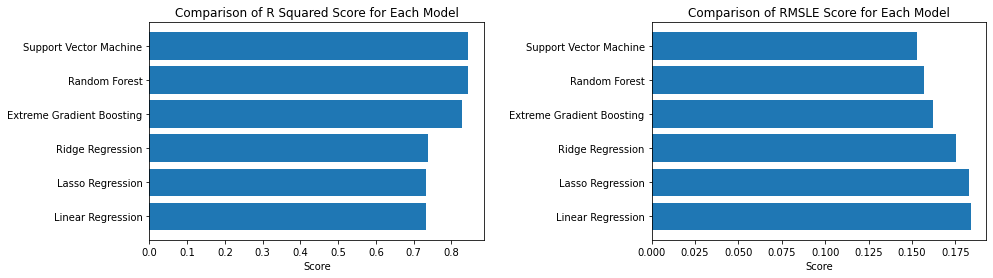

In [25]:
plt.figure(figsize=(15,4))

plt.subplot(1, 2, 1)
model_df = pd.DataFrame({'Model': models, 'R Squared': r_squared_list,'RMSLE': rmsle_list})
model_df = model_df.sort_values(by=['R Squared'], axis=0, ascending=True)
plt.barh(model_df.Model, model_df['R Squared'])
plt.xlabel('Score')
plt.title("Comparison of R Squared Score for Each Model")

plt.subplot(1,2,2)
model_df = model_df.sort_values(by=['RMSLE'], axis=0, ascending=False)
plt.barh(model_df.Model, model_df['RMSLE'])
plt.xlabel('Score')
plt.title("Comparison of RMSLE Score for Each Model")

plt.subplots_adjust(wspace=0.5)
plt.show()

As we can see, the order of fitness of each model goes:

SVM > Random Forest > Extreme Gradient Boosting > Ridge Regression > Lasso Regression > Linear Regression.

It actually matches up perfectly! So, in order to make my submission, I will use the Support Vector Machine. 

## Prepare the Submission

Now to download the test data and get it into a suitable format so that a submission can be made.

In [26]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
test_data.shape

(1459, 80)

So there are 1459 houses, plus 80 features. This makes sense as there are the 81 features from the training dataset minus the price. We need to now change the columns so that they're in the exact same format as the training dataset.

In [27]:
test_data['HasAlley'] = ~(test_data.Alley.isnull())
test_data['HasFireplace'] = ~(test_data.FireplaceQu.isnull())
test_data['HasPool'] = ~(test_data.PoolQC.isnull())
test_data['HasMisc'] = ~(test_data.MiscFeature.isnull())
test_data['HasGarage'] = ~(test_data.GarageFinish.isnull())

x_test = test_data[categorical_to_keep + numerical_to_keep]
x_test = x_test[features]
x_test = pd.get_dummies(x_test)

#add the missed columns from when using pd.get_dummies
x_test = x_test.reindex(columns = x.columns, fill_value=0)
x_test.shape

(1459, 67)

Now we need to standardise and transform these columns.

In [28]:
standardise = preprocessing.StandardScaler().fit(x_test[numerical_to_keep])
x_test[numerical_to_keep] = standardise.transform(x_test[numerical_to_keep])

Now we need to test for missing values.

In [29]:
x_test.isna().sum()

OverallQual              0
YearBuilt                0
YearRemodAdd             0
1stFlrSF                 0
GrLivArea                0
                        ..
SaleCondition_AdjLand    0
SaleCondition_Alloca     0
SaleCondition_Family     0
SaleCondition_Normal     0
SaleCondition_Partial    0
Length: 67, dtype: int64

Garage Area is missing one value! Let's fill it with the median.

In [30]:
x_test['GarageArea'] = x_test['GarageArea'].fillna(x_test['GarageArea'].median())

Now to make the submission using the SVM regressor!

In [31]:
predictions = SVM.predict(x_test)
test_data = pd.read_csv('test.csv')
submission_df = pd.DataFrame({'Id': test_data['Id'], 'SalePrice': predictions})
submission_df.to_csv('submission.csv',index=False)